In [1]:
import random
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import train_due
from coati.utils.chem_explore import embed_and_score_in_batches_regression
import argparse
import os.path as osp
from coati.utils.chem import read_sdf, write_sdf, read_pkl, write_pkl, read_txt
from rdkit import Chem

def clean_smiles(smiles):
    cleaned = smiles.replace('[C]', 'C').replace('[O]', 'O').replace('[N]', 'N').replace('[F]', 'F').replace('[Br]', 'Br')
    cleaned = cleaned.replace('[c]', 'c').replace('[n]', 'n').replace('[o]', 'o').replace('[s]', 's')
    return cleaned

def convert_smiles(mols_list):
    normal_smiles = []
    for mol in mols_list:
        try:
            smi = Chem.MolToSmiles(mol)
            cleaned_smi = clean_smiles(smi)
            mol = Chem.MolFromSmiles(cleaned_smi)
            if mol is not None:
                normal_smi = Chem.MolToSmiles(mol)
                normal_smiles.append(normal_smi)
            else:
                normal_smiles.append(None)
        except Exception as e:
            normal_smiles.append(None)
            print(f"Error processing SMILES '{smi}': {e}")
    return normal_smiles

def token_clean(smi, tokenizer):
    try:
        if smi != "*":
            tokenizer.tokenize_text("[SMILES]" + smi + "[STOP]", pad=True)
            return smi
    except Exception as e:
        print(f"Error tokenize SMILES '{smi}'")
    return None

In [2]:
arg_parser = argparse.ArgumentParser(description='Train a model on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = 'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--train_smiles', type=str, default='data/all.smi')
arg_parser.add_argument('--cached_data', type=str, default='data/trained_diff_property_4w.pt')
arg_parser.add_argument('--task', type=str, default='logp')
arg_parser.add_argument('--ckpt_dir', type=str, default='model_ckpts')
args = arg_parser.parse_args([])


In [3]:
# model define

DEVICE = args.device
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [4]:
regen_data = True
if osp.exists(args.cached_data) and (not regen_data):
    subset = torch.load(args.cached_data)
else:
    train_smiles = args.train_smiles
    with open(train_smiles) as f:
        train_smiles = [line.strip('\n') for line in f][:100000]
    random.shuffle(train_smiles)
    mols = read_sdf('./data/all_target_diff.sdf')
    target_diff_smiles = convert_smiles(mols)
    target_diff_smiles = token_clean(target_diff_smiles, tokenizer)
    train_smiles = list(set(train_smiles[:40000] + target_diff_smiles))
    subset = [{"smiles": s, "source": "demo_mols"} for s in train_smiles]
    embed_and_score_in_batches_regression(subset, encoder, tokenizer)
    

Error processing SMILES '[C]C(=O)[C]1[C][C][C]O[C]2[C][C]([C]([O])[C][C][C]2[C]2O[C]O2)[C]1[O]': Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)
Error processing SMILES '[O][C]1[C][C][C]2[N][C]1C(=O)[N]c1[c][c][c]c3c1[C]([C][C][C][C]C3=O)[N]2': Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)
Error processing SMILES '[O][C]1[C][C@@]12[C][C][C@]13[C]N1

371batch [02:29,  2.49batch/s]                      


In [5]:
torch.save(subset, args.cached_data)

In [6]:
args.task = 'qed'
qed_model, qed_res = train_due(
    subset,
    x_field="emb_smiles",
    y_field=args.task,
    save_as= osp.join(args.ckpt_dir, "regression_diff_more_"+args.task+".pt"),
    continue_training=True,
    steps=1e5,
    random_seed=2023
    )
qed_model = qed_model.to(DEVICE)

Training with 1423 datapoints for 33334.0 epochs
Results - Epoch: 3334 - Test Likelihood: 8.39 - Loss: -2.31
Results - Epoch: 6668 - Test Likelihood: 13.55 - Loss: -2.57
Results - Epoch: 10002 - Test Likelihood: 15.88 - Loss: -2.60
Results - Epoch: 13336 - Test Likelihood: 17.65 - Loss: -2.65
Results - Epoch: 16670 - Test Likelihood: 18.44 - Loss: -2.68
Results - Epoch: 20004 - Test Likelihood: 20.40 - Loss: -2.69
Results - Epoch: 23338 - Test Likelihood: 21.32 - Loss: -2.74
Results - Epoch: 26672 - Test Likelihood: 21.75 - Loss: -2.75
Results - Epoch: 30006 - Test Likelihood: 22.70 - Loss: -2.77


In [35]:
import matplotlib.pyplot as plt

def get_due_plot(due_result, y_field="qed", save_name="regression_plot.png"):
    """Plots the DUE model regressed results."""

    # xs are the true values, ys are the predicted values, dys are the errors.
    xs, ys, dys = due_result

    fig, ax = plt.subplots(figsize=(11, 6))
    n_to_plot = 30000
    # plt.style.use("seaborn-v0_8-pape")
    ax.errorbar(
        (xs[:n_to_plot]),
        (ys[:n_to_plot]),
        yerr=dys[:n_to_plot],
        fmt="o",
        color="black",
        ecolor="lightgray",
        elinewidth=3,
        capsize=0,
    )
    plt.xlabel("True " + y_field)
    plt.ylabel("Regressed " + y_field)
    plt.savefig(save_name)

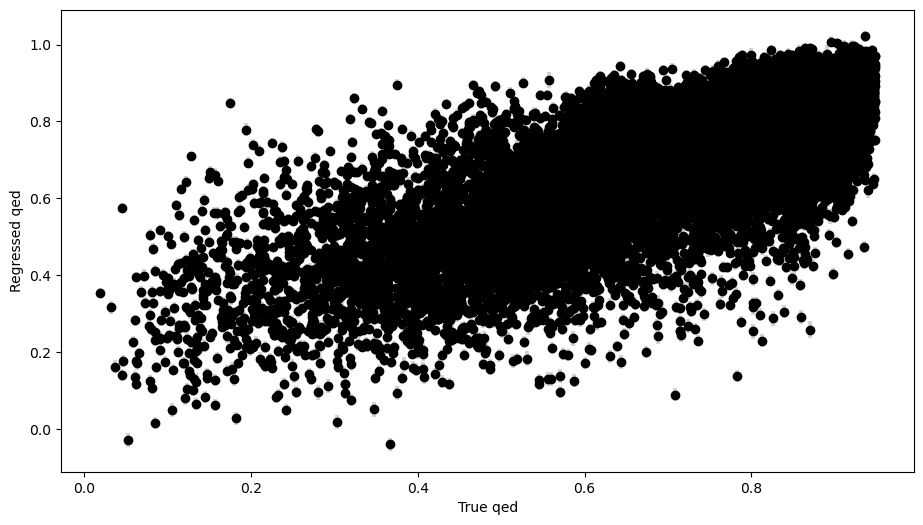

In [36]:
get_due_plot(qed_res, y_field=args.task, save_name=args.task+"_regression_plot.png")